# m<sup>6</sup>A Modification Models
## Mitchel Cole
## July 31, 2020

In [ ]:
from datetime import date
print('Last Updated On: ', date.today())

# Intro & Recap

The goal of the notebook is to build a couple of models of m<sup>6</sup>A status
and to compare performance with models from Zhang et al 2018
(BMC Bioinformatics) and Zhao et al 2018 (BMC Genomics).

Features

- 201 bp sequence centered at m<sup>6</sup>A
- GC content of sequence
- Purine content of sequence
- Amino content of sequence
- 1-3mer frequencies of sequence
- Shannon Entropy
- PhyloP scores for each bp

I initially thought histone marks may be helpful, but from my 
[previous analysis](../R/20200713_m6a_feature_exploration.html), I thought
m<sup>6</sup>A marks were associated with active transcription (H3K9me3, H3K4me1,
H3K36me3). Upon reading about H3K36me3 and it's association with RNA splciing
(Sun Z et al. Cell & Biosci. 2020), that makes a lot of sense... I am initially
excluding histone features due to availability of the data. If these models
are unsuccessful, I will add H3K36me3 status to the feature list.

Datasets

- Training:
    * HEK293 (Linder et al 2015)
- Testing:
    * CD8 T cells (Ke et al 2015)
    * A549 cells (Ke et al 2015)

I removed HEK293 DART-Seq data because I didn't see the DRACH motif enriched
when I performed motif analysis on the bed files from the paper
(Meyer. Nat Methods. 2019). 

TODO: Read the paper again

Models

- Logistic
- Random Forest
- CNN (probably will encode conservation score in sequence array, similar to Mehran's model from his lab meeting last week)

# Feature Check

One last check to see if feature distributions are normal/correlated. I am
expecting the kmer/gc content to be correlated

In [2]:
import pandas as pd
import re
# Look at training and testing data
bp_window = 201
df = pd.read_csv("../processed_data/20200918_training.csv.gz")
df = df.dropna()

bp_cols = ['bp_{}'.format(i) for i in range(201)]
bp_cat = pd.api.types.CategoricalDtype(categories=['A','C','G','T'],
                                      ordered=False)
df[bp_cols] = df[bp_cols].astype(bp_cat)

#remove false negative m6a sequences
df['seqs'] = df[bp_cols].agg(''.join, axis=1)
df = df.sort_values(['seqs','group'], ascending=[True, False])
df = df[~df.duplicated(subset='seqs') | df['group'] == 1]
del df['seqs']

# Normalize kmer space from 0-1
p = re.compile('[ACTG]+')
kmer_cols = [x for x in df.columns if p.match(x)]

Text(0.5, 0.98, 'PhyloP Distributions')

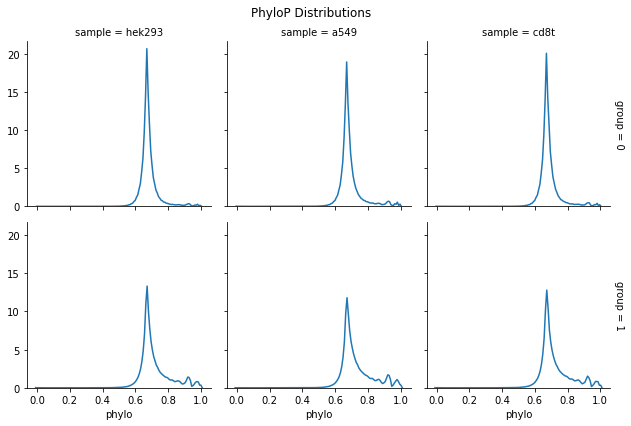

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# conservation scores
phylo_cols = [x for x in df.columns if "phylo" in x]
df_scores_long = df.melt(
    id_vars=['sample','group'],
    value_vars=phylo_cols,
    var_name="bp", 
    value_name="phylo"
)

g = sns.FacetGrid(df_scores_long, col="sample", row="group", margin_titles=True)
g.map(sns.kdeplot, "phylo")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("PhyloP Distributions")

The second hump in around a score of 10 in the m6A samples appears prominent.
Mostly normal distributions. I thought I drew the same sequences as background
for all samples but the jaccard similarity between the backgrounds was a max of
0.0039 for ${3 \choose 2}$ combinations. The max jaccard statistic between the
m<sup>6</sup>A samples was 0.26. Remeber to filter out overlaps from training
and testing datasets.

Text(0.5, 0.98, 'PhyloP Positional Pearson Correlation')

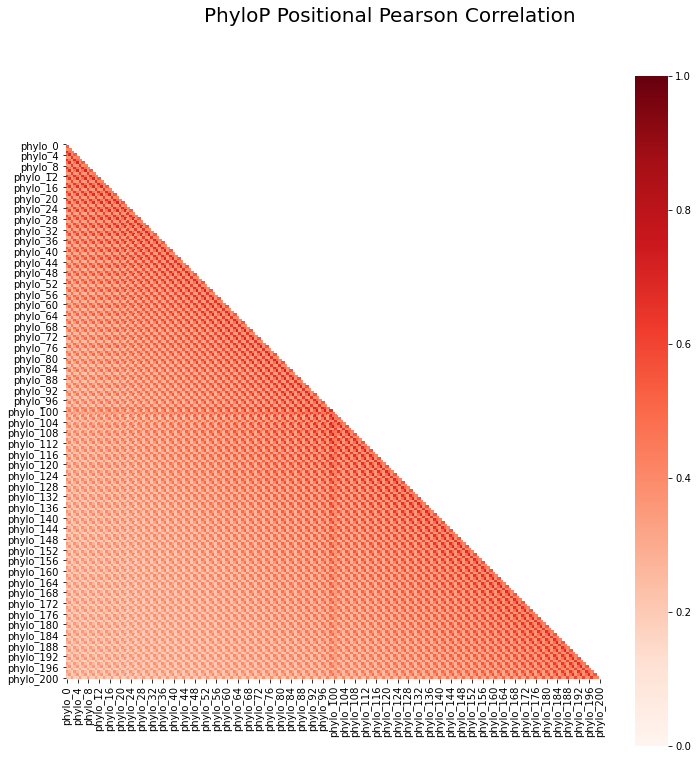

In [4]:
import numpy as np

cor_phylo = df[phylo_cols].corr()
fig, ax = plt.subplots(1,1, figsize=(12, 12))
mask = np.zeros_like(cor_phylo)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(cor_phylo, ax=ax, vmin=0, vmax=1, mask=mask, square=True,
                 cmap="Reds")
fig.subplots_adjust(top=0.9)
fig.suptitle('PhyloP Positional Pearson Correlation', size=20)

It looks like if the DRACH is methlyated (position 100) then the entire neighborhood
appears to have similar phyloP scores

Text(0.5, 0.98, 'K-mer Pearson Correlation')

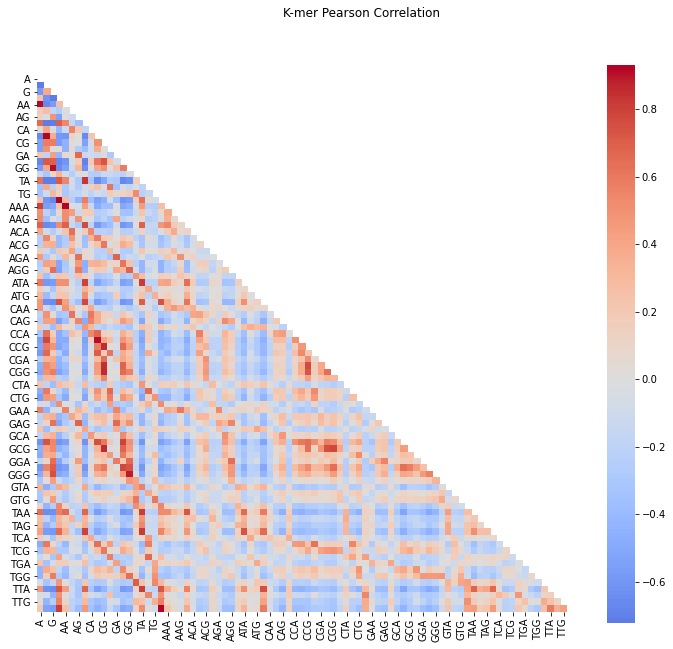

In [5]:
cor_kmer_counts = df[kmer_cols].corr()
fig, ax = plt.subplots(1,1, figsize=(12, 10))
mask = np.zeros_like(cor_kmer_counts)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(cor_kmer_counts, ax=ax, center=0, mask=mask, square=True, cmap="coolwarm")
fig.subplots_adjust(top=0.9)
fig.suptitle('K-mer Pearson Correlation')

Purine content is in between gc and amino content. Entropy is after "TTT".
Many of these features are probably redundant.

Text(0.5, 0.98, 'Entropy Distributions')

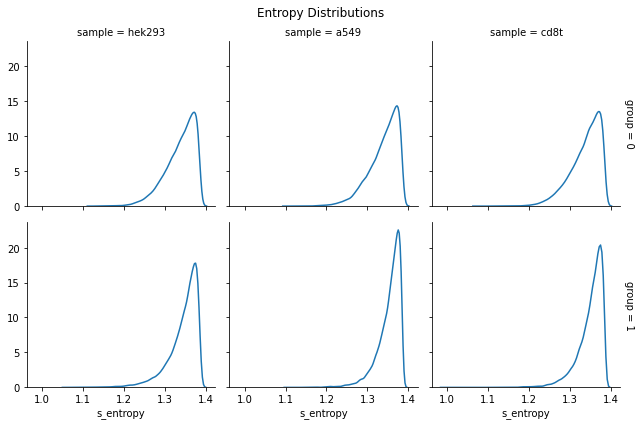

In [6]:
g = sns.FacetGrid(df, col="sample", row="group", margin_titles=True)
g.map(sns.kdeplot, "s_entropy")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Entropy Distributions")

Max sequence entropy is $-\sum^4_1\frac{1}{4}\ln\left(\frac{1}{4}\right)=1.38$.
So, presumably low GC probability  in background prevents secondary structure
formation in background sequences...

Next, I will try to reduce the Base Pair property feature space with PCA. I'll
take the number of components necessary to explain 95% of the variance

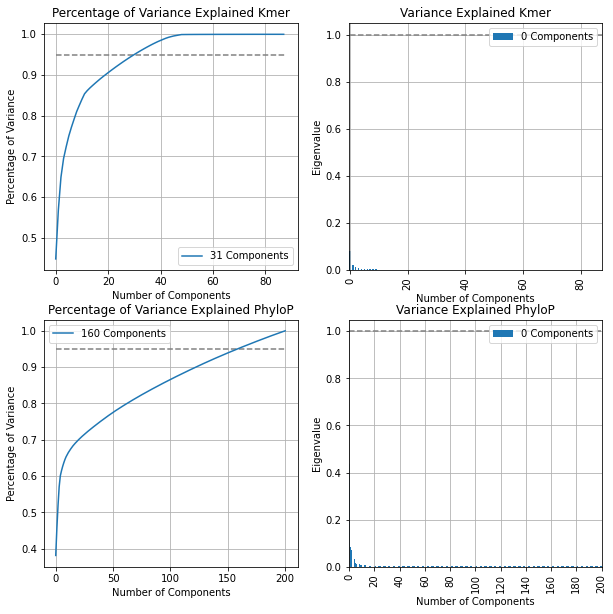

In [7]:
from sklearn.decomposition import PCA

df_train = df[df["sample"] == "hek293"]

def plotPCA(df, ax, cols):
    pca = PCA(random_state=0)
    pca.fit(df.values)
    var_exp = pd.Series(pca.explained_variance_ratio_).cumsum()
    n_comps = (var_exp > 0.95).idxmax() + 1
    var_exp.plot(ax=ax, title="Percentage of Variance Explained {}".format(cols),
            grid=True, xlabel="Number of Components", ylabel="Percentage of Variance",
            label='{} Components'.format(n_comps))
    ax.hlines(0.95, xmin=0, xmax=len(df.columns), color="grey", linestyles="--")
    ax.legend(loc='best')
    return n_comps

def plotScree(df, ax, cols):
    pca = PCA(random_state=0)
    pca.fit(df.values)
    df_var_exp = pd.DataFrame(list(enumerate(pca.explained_variance_)),
                             columns=["Principal Component","Eigenvalue"])

    n_comps = (df_var_exp["Eigenvalue"] < 1).idxmax()
    
    df_var_exp.plot.bar("Principal Component","Eigenvalue",
                       ax=ax, title="Variance Explained {}".format(cols),
                       grid=True, xlabel="Number of Components",
                       ylabel="Eigenvalue",
                       label="{} Components".format(n_comps))
    ax.hlines(1, xmin=0, xmax=len(df.columns), color="grey", linestyles="--")
    ax.legend(loc="best")
    ax.xaxis.set_ticks(np.arange(0, len(df.columns) + 1, 20))
    
fig, axes = plt.subplots(2, 2, figsize=(10,10))

pca_cols_bp = kmer_cols + ['gc_content', 'amino_content', 'purine_content', 's_entropy']
pca_cols_phylo = phylo_cols

n_comps_bp = plotPCA(df_train[pca_cols_bp], axes[0][0], "Kmer")
plotScree(df_train[pca_cols_bp], axes[0][1], "Kmer")
n_comps_phylo = plotPCA(df_train[pca_cols_phylo], axes[1][0], "PhyloP")
plotScree(df_train[pca_cols_phylo], axes[1][1], "PhyloP")

In [8]:
def printLoadings(pca, cols, comp):
    df_loadings = pd.DataFrame(
        np.transpose(pca.components_),
        columns=['Component {}'.format(i + 1) for i in range(pca.components_.shape[0])],
        index=cols
    )
    df_loadings['abs_eigen'] = abs(df_loadings['Component {}'.format(comp)])
    df_loadings = df_loadings.sort_values(by="abs_eigen", ascending=False).head(10)
    s_loading = df_loadings['Component {}'.format(comp)]
    print(s_loading)

pca_bp = PCA(n_components=n_comps_bp, random_state=0)
pca_bp.fit(df_train[pca_cols_bp].values)

pca_phylo = PCA(n_components=n_comps_phylo, random_state=0)
pca_phylo.fit(df_train[pca_cols_phylo].values)

PCA(n_components=160, random_state=0)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

bp_categories = [['A','C','G','T'] if i != 100 else ['A'] for i in range(201)]
column_trans = ColumnTransformer(
    [('bp_category', OneHotEncoder(categories=bp_categories, drop='first', dtype='int'), bp_cols),
     ('pca_bp', PCA(n_components=n_comps_bp, random_state=0), pca_cols_bp),
     ('pca_phylo', PCA(n_components=n_comps_phylo, random_state=0), pca_cols_phylo)],
    remainder='drop')

column_trans.fit(df_train)

features = column_trans.transformers_[0][1].get_feature_names().tolist() + \
["pca_bp_{}".format(i) for i in range(n_comps_bp)] + \
["pca_phylo_{}".format(i) for i in range(n_comps_phylo)]

In [10]:
df_test_cd8 = df[df["sample"] == "cd8t"]

df_test_a549 = df[df["sample"] == "a549"]

In [11]:
for sample, df_temp in zip(["Training|HEK", "Testing|CD8", "Testing|A549"],
                      [df_train, df_test_cd8, df_test_a549]):
    print(sample)
    print(df_temp["group"].value_counts(),"\n")

Training|HEK
0    24715
1    20536
Name: group, dtype: int64 

Testing|CD8
0    24770
1    19670
Name: group, dtype: int64 

Testing|A549
0    24867
1    23472
Name: group, dtype: int64 



In [12]:
def preprocessOneHot(df):
    # Create input array for one hot encoded sequence models
    # Change encoding from binary to conservation score
    
    # sequence
    y = df["group"].values
    X = column_trans.transform(df)
    
    return X, y

In [13]:
X_train, y_train = preprocessOneHot(df_train)

X_test_cd8, y_test_cd8 = preprocessOneHot(df_test_cd8)
X_test_a549, y_test_a549 = preprocessOneHot(df_test_a549)

# Logistic

Using RFECV to determine optimal features
with stratified 5-fold validation.

## Feature Importance

In [14]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(random_state=0, max_iter=1600)

step=30
selector_log = RFECV(log, step=step, cv=5, n_jobs=4, scoring="accuracy", verbose=1)
selector_log.fit(X_train, y_train)

Fitting estimator with 791 features.
Fitting estimator with 761 features.
Fitting estimator with 731 features.
Fitting estimator with 701 features.
Fitting estimator with 671 features.
Fitting estimator with 641 features.
Fitting estimator with 611 features.
Fitting estimator with 581 features.
Fitting estimator with 551 features.
Fitting estimator with 521 features.
Fitting estimator with 491 features.
Fitting estimator with 461 features.


RFECV(cv=5, estimator=LogisticRegression(max_iter=1600, random_state=0),
      n_jobs=4, scoring='accuracy', step=30, verbose=1)

In [15]:
def plotFeatures(feat, model, n=10):
    """show optimal number of features show horiz barplot of top nfeature
    importances"""
    # model is RFECV object, feat is list of original feature names
    n_feats_total = len(model.get_support())
    n_feats_best = model.n_features_
    
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    
    axes[0].set_xlabel("Number of features selected")
    axes[0].set_ylabel("Metric")
    lst_feats = list(range(n_feats_total, 1, -step)) + [1]
    lst_feats = lst_feats[::-1]
    axes[0].plot(lst_feats, model.grid_scores_)
    axes[0].axvline(x=n_feats_best, linestyle="--",
                    label="{} Features".format(n_feats_best), color="grey")
    axes[0].legend(loc="best")
    axes[0].set_title("RFECV Performance on Training Data")
    
    df_feats = pd.DataFrame(zip(feat, model.support_), columns=["Feature","Support"])
    feats_best = df_feats[df_feats["Support"]]["Feature"].values
    
    if hasattr(model.estimator_, "coef_"):
        feat_impt = model.estimator_.coef_[0]
        xlabel = "Log OR"
    else:
        feat_impt = model.estimator_.feature_importances_
        xlabel = "Gini Importance"
 
    df = pd.DataFrame(list(zip(feats_best, feat_impt)),
                      columns=["Feature", "Importance"])
    df["Rank"] = df["Importance"].abs().rank(ascending=False)
    df = df.sort_values("Rank", ascending=True).head(n)
  
    df.plot.barh(x="Feature", y="Importance", ax=axes[1], legend=False,
                title="Feature Importance")
    axes[1].axvline(x=0, linestyle="--", color="black")
    axes[1].set_xlabel(xlabel)
    
    fig.tight_layout()

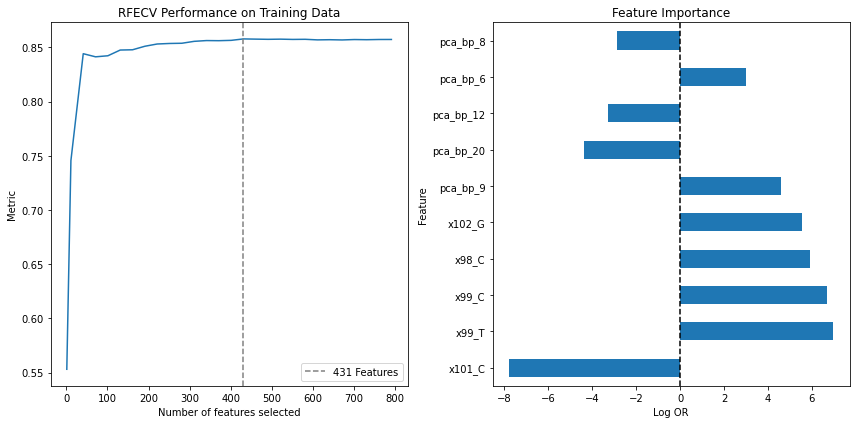

In [16]:
plotFeatures(features, selector_log, 10)

In [17]:
printLoadings(pca_bp, pca_cols_bp, 10) #1 indexed

GT    -0.299873
AG    -0.294047
AC     0.293834
GA     0.289704
CAG   -0.242465
AGT   -0.217574
TGA    0.211290
GAC    0.177239
ACT    0.161855
AGC   -0.141679
Name: Component 10, dtype: float64


Metric in these CV estimators is accuracy. I can explain bp_101_C having such a
large coefficient. I seleced DRACH motifs with 0 mismatches for background so
any deviation from C is found in m6A samples. I guess it raises the question
what the background should be. The BP 98 C and BP 102 G seem interesting
candidates for potential stem loop.

## CD8 T Cells

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

def plotMetrics(model, X, Y):
    # print classification_report
    # plot confusion matrix, ROC, Precision Recall
    
    Y_pred = model.predict(X)
    print(classification_report(Y, Y_pred))
    
    conf_mat = confusion_matrix(Y, Y_pred)
    df_conf_mat = pd.DataFrame(conf_mat, index=["Actual Background", "Actual m6A"],
                              columns=["Predicted Backgroud", "Predicted m6A"])
    
    fig, axes = plt.subplots(1, 3, figsize=(18,6))
    
    sns.heatmap(df_conf_mat, vmax=25000, cmap="Blues", annot=True, fmt=".3g", ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    
    plot_roc_curve(model, X, Y, ax=axes[1])
    xs = np.linspace(0, 1, 100)
    axes[1].plot(xs, xs, linestyle="--", c="grey")
    axes[1].set_title("ROC Curve")
    
    plot_precision_recall_curve(model, X, Y, ax=axes[2])
    axes[2].plot(xs, np.flip(xs), linestyle="--", c="grey")
    axes[2].set_title("Precision Recall Curve")

              precision    recall  f1-score   support

           0       0.76      0.89      0.82     24770
           1       0.82      0.65      0.73     19670

    accuracy                           0.78     44440
   macro avg       0.79      0.77      0.77     44440
weighted avg       0.79      0.78      0.78     44440



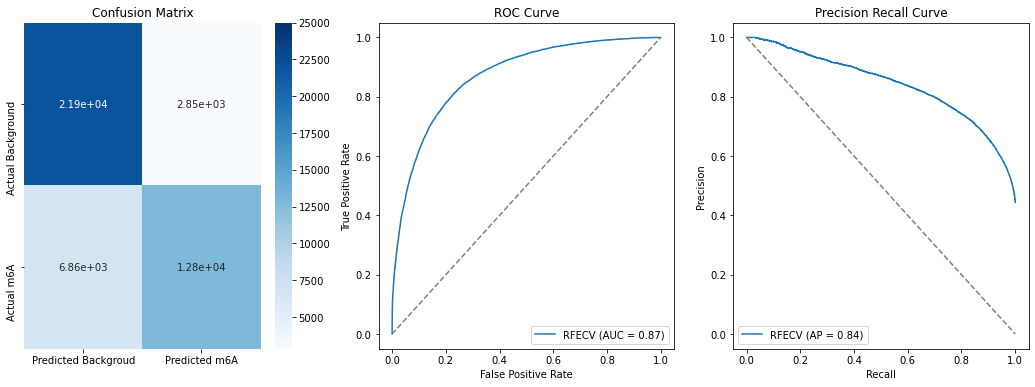

In [22]:
plotMetrics(selector_log, X_test_cd8, y_test_cd8)

## A549 Cells

              precision    recall  f1-score   support

           0       0.75      0.85      0.79     24867
           1       0.81      0.69      0.75     23472

    accuracy                           0.77     48339
   macro avg       0.78      0.77      0.77     48339
weighted avg       0.78      0.77      0.77     48339



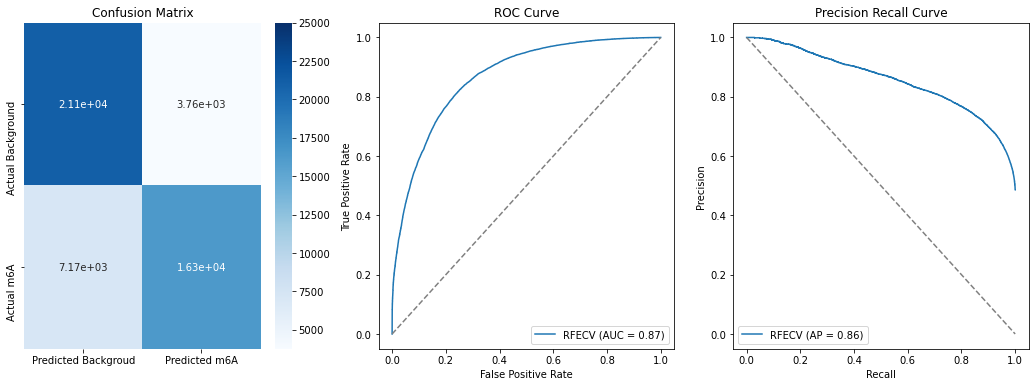

In [23]:
plotMetrics(selector_log, X_test_a549, y_test_a549)

The performance looks decent. Next, I will look at the most important features
by absolute value of coefficients.

# Random Forest

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0, n_jobs=1)
params = {
    'n_estimators': [100, 200, 400, 800],
    'max_depth': [4, 16, 32],
    'min_samples_leaf':[1, 2, 4],
    'max_features': ['sqrt','log2']
}
clf_rf = GridSearchCV(rf, params, scoring="accuracy", n_jobs=4, cv=5)
clf_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1, random_state=0),
             n_jobs=4,
             param_grid={'max_depth': [4, 16, 32],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [100, 200, 400, 800]},
             scoring='accuracy')

In [25]:
print(clf_rf.best_params_)

{'max_depth': 32, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}


## Feature Importance

In [26]:
selector_rf = RFECV(clf_rf.best_estimator_, step=step, cv=5, n_jobs=4, scoring="accuracy", verbose=1)
selector_rf.fit(X_train, y_train)

Fitting estimator with 791 features.
Fitting estimator with 761 features.
Fitting estimator with 731 features.
Fitting estimator with 701 features.
Fitting estimator with 671 features.
Fitting estimator with 641 features.
Fitting estimator with 611 features.
Fitting estimator with 581 features.
Fitting estimator with 551 features.
Fitting estimator with 521 features.
Fitting estimator with 491 features.
Fitting estimator with 461 features.
Fitting estimator with 431 features.
Fitting estimator with 401 features.
Fitting estimator with 371 features.
Fitting estimator with 341 features.
Fitting estimator with 311 features.
Fitting estimator with 281 features.
Fitting estimator with 251 features.
Fitting estimator with 221 features.
Fitting estimator with 191 features.
Fitting estimator with 161 features.
Fitting estimator with 131 features.
Fitting estimator with 101 features.
Fitting estimator with 71 features.


RFECV(cv=5,
      estimator=RandomForestClassifier(max_depth=32, max_features='sqrt',
                                       min_samples_leaf=2, n_estimators=200,
                                       n_jobs=1, random_state=0),
      n_jobs=4, scoring='accuracy', step=30, verbose=1)

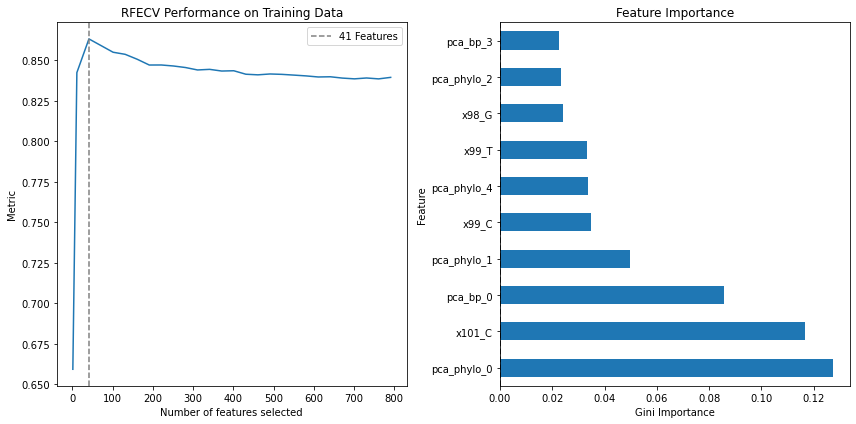

In [27]:
plotFeatures(features, selector_rf, 10)

In [28]:
printLoadings(pca_phylo, pca_cols_phylo, 1) #1 indexed
printLoadings(pca_bp, pca_cols_bp, 1)

phylo_99     0.095397
phylo_94     0.089019
phylo_100    0.088577
phylo_85     0.088296
phylo_82     0.088084
phylo_88     0.087745
phylo_106    0.087743
phylo_91     0.087723
phylo_79     0.087682
phylo_115    0.087214
Name: Component 1, dtype: float64
gc_content    0.409815
TT           -0.264000
AA           -0.247317
CC            0.230497
C             0.218541
T            -0.210686
GG            0.202908
A            -0.199129
TTT          -0.194307
TA           -0.194098
Name: Component 1, dtype: float64


## CD8 T Cells

              precision    recall  f1-score   support

           0       0.79      0.84      0.81     24770
           1       0.78      0.72      0.75     19670

    accuracy                           0.78     44440
   macro avg       0.78      0.78      0.78     44440
weighted avg       0.78      0.78      0.78     44440



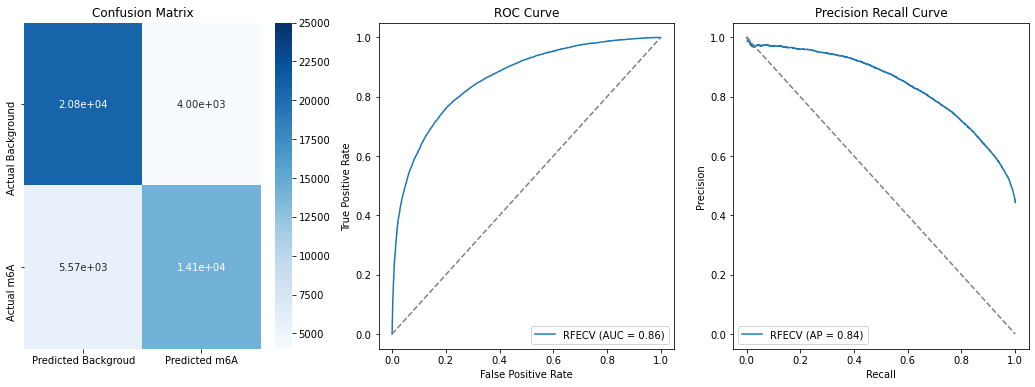

In [29]:
plotMetrics(selector_rf, X_test_cd8, y_test_cd8)

## A549 Cells

              precision    recall  f1-score   support

           0       0.78      0.79      0.78     24867
           1       0.77      0.77      0.77     23472

    accuracy                           0.78     48339
   macro avg       0.78      0.78      0.78     48339
weighted avg       0.78      0.78      0.78     48339



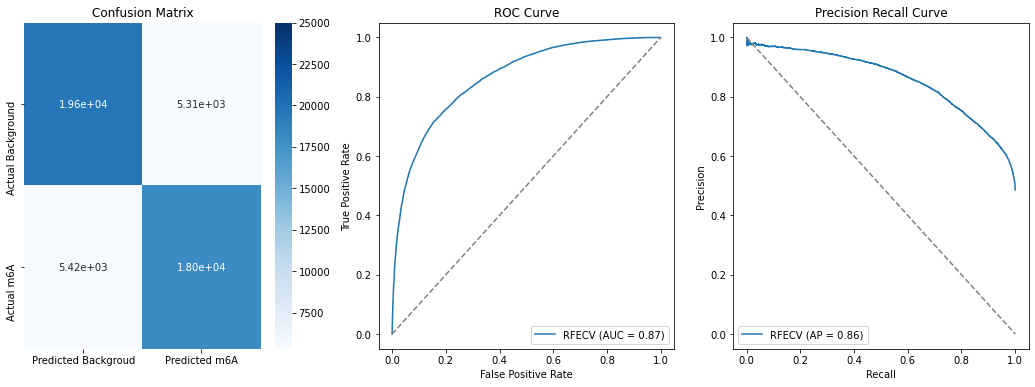

In [30]:
plotMetrics(selector_rf, X_test_a549, y_test_a549)

In [31]:
from joblib import dump

dump(selector_log, 'log_rfecv.joblib')
dump(selector_rf, 'rf_rfecv.joblib')
dump(column_trans, 'column_transformer.joblib')

['column_transformer.joblib']